The next cell sets some constant simulation parameters.

In [1]:
using PyPlot

# simulations parameters

const T=1600.0
const dt=0.01
const Tdt=convert(Int64,T/dt)
t = range(dt,stop=T,length=Tdt)
#t=linspace(0,T,Tdt)

0.01:0.01:1600.0

Network node dynamics are modeled as either linear or nonlinear. In particular, DNL are always modeled as first-order nonlinear systems. Other nodes are usually modeled as linear. This choice is motivated by reducing overfitting.

Linear nodes variables $y$ satisfy the differential equation:
$$\dot y = \varepsilon(-y+u),$$
where $u$ is the input to the node and $\varepsilon=0.5$ in the present model.

Nonlinear nodes variables satisfy the differential equation:
$$\dot y=-y+\frac{1}{1+e^{-4(\beta y+u-u_{1/2})}}.$$
The sigmoidal input function $\frac{1}{1+e^{-4(u-u_{1/2})}}$ reaches its maximum slope at $u=u_{1/2}$. The factor $4$ enforces the maximum slope to be one. In our model we set $u_{1/2}=0.5$. The term $\beta y$ models either autocatalysis ($\beta>0$) or nonlinear degradation $(\beta<0)$.

In the end, the only free node parameters are the $\beta$'s appearing in nonlinear nodes dynamics. The next cell creates the various functions needed in the node dynamics.


In [2]:
const eps=0.5

#dynamic functions
boltz(u::Float64,u12::Float64)=1/(1+exp(-4*(u-u12)))
node_dyn(y::Float64,beta::Float64,u::Float64)=-y+boltz(beta*y+u,0.5)
slow_dyn(y::Float64,u::Float64)=eps*(-y+u)

slow_dyn (generic function with 1 method)

The next cell creates the network model and simulate the resulting dynamical system with a simple forward Euler loop. Let us describe the proposed network model (see commented code for other details).

We modeled the dynamics of the TIM, MOV, and SWI DPMs, plus a couple of output nodes (DevRST and MazF) under the effect of the input node NUT. NUT is supposed to switch off at time 350 (this is an abstract model, so time units are arbitrary).

We solely model the loop part of the TIM DPM, which includes nodes MrpC2 (xe), PktA2 (ye1), MkapA (ye2), PktC2 (ye3), PskA5 (ye4). Names in parenthesis are the one used in the code. MkapA is the DPM input nodes. The DNL MrpC2 is the DPM output node. The node MrpC2 is the only node exhibiting nonlinear dynamics. In line with experiments, this nodes is supposed to exhibit autocatalysis. We choose unitary interconnection gain for each arrow in the loop (with the appropriate sign). Input to node MkapA (ye2) from node NUT is modeled as follows. NUT provides input to this node via two parallel paths of opposite total gain: a short path (mediated by PktD9) with negative gain and a long path (mediated by PEP,PktD1,MkapB,PktA4) with positive gain. This is a realization of an incoherent feedword with fast inhibition and delayed excitation. Since NUT switches off, the sign is reversed and we can model the input from NUT to MkapA as the typical timecourse of fast excitatory/slow inhibitory incoherent feedforward loop. This is a rapidly increasing and then slowly decreasing bump. We model this bump as
$$Input_{NUT\to MkapA}(t)=\frac{1}{2}(\tanh(t-350)+1) - \frac{1}{2}(\tanh(0.5(t-355))+1), $$
which is bump of activity that start to rapdily (unitary speed) increase at around time $t=350$ and then slowly (speed=0.5) decrease at around time $t=355$. We also assume a small ($0.02$) steady state input to node Mrpc2. This input, like other steady state input appearing in other nonlinear nodes models the effect of other part of the network not considered here.

The DevRST (dev) node is assumed to have a nonlinear dynamics with a small nonlinear degradation term. It also receives inputs from node MrpC2 (xe) with gain $0.5$ and from node FruA (xo) with gain $2.0$, and it is assumed to be affected by a steady state input $-1.0$.

The MOV DPM is modeled similarly to the TIM DPM. The only nonlinear (and autocatalytic) node is FruA. Interconection gains along the loop are all unitary (with the appropiate sign). FruA is in this DPM both the input and output node. It receive inputs from MrpC2 with gain $0.5$, from DevRST with input $0.1$, and from CsgA (swi2) with gain $0.4$.

The set of nodes RelA, SocE, CsgA constitutes the bistable switch DPM SWI. This DPM is inhibited by NUT, and therefore excited when NUT switches off. We modeled its dynamics as simple two nodes (swi1 and swi2) bistable switch that receive a positive input at time $t=350$. We assume this bistable switch to be in its low state at time $t=0$.

Finally, the output node MazF is assumed to be governed by and outcatalytic bistable switch, initially in its low state.




In [32]:
function integration_loop()
    
    #generation of the output vectors
    
    xe_out=zeros(Tdt)
    ye1_out=zeros(Tdt)
    ye2_out=zeros(Tdt)
    ye3_out=zeros(Tdt)
    ye4_out=zeros(Tdt)
    
    dev_out=zeros(Tdt)
    
    xo_out=zeros(Tdt)
    yo1_out=zeros(Tdt)
    yo2_out=zeros(Tdt)
    yo3_out=zeros(Tdt)
    
    swi1_out=zeros(Tdt)
    swi2_out=zeros(Tdt)
    
    maz_out=zeros(Tdt)
    
    #setting initial conditions
    
    xe=0.17
    ye1=0.17
    ye2=0.17
    ye3=0.17
    ye4=0.17
    
    dev=0.15
    
    xo=rand(1,1)[1]
    yo1=rand(1,1)[1]
    yo2=rand(1,1)[1]
    yo3=rand(1,1)[1]
    
    swi1=0.9
    swi2=0.1
    
    maz=0.1
    
    #integration loop
    
    for h=1:convert(Int64,Tdt)
        
        #excitable (TIM) subnetwork dynamics, DNL: MrpC2

        xe_temp=xe+dt*node_dyn(xe,1.5,-ye4-0.02)  #1.5 -0.02  ; dt/4 in the others, and -0.063
        ye1_temp=ye1+dt*slow_dyn(ye1,xe+0.075*dev-0.05)
        ye2_temp=ye2+dt*slow_dyn(ye2, ye1 + 0.0*(sign(h*dt-750)+1)*(tanh(1.0*(h*dt-750))) - 0.5*(sign(h*dt-750)+1)*(tanh(0.5*(h*dt-755))) )
        ye3_temp=ye3+dt*slow_dyn(ye3,ye2)
        ye4_temp=ye4+dt*slow_dyn(ye4,ye3)
        
        #DevRST output node dynamics
        
        dev_temp=dev+0.01*dt*node_dyn(dev,-0.1,1.5*xe+1.7*xo-0.9)
        
        #oscillatory (MOV) subnetwork dynamics, DNL: FruA
        
        xo_temp=xo+dt*node_dyn(xo,1.5,0.5*xe+0.2*dev-yo3+0.4swi2)
        yo1_temp=yo1+dt*slow_dyn(yo1,xo)
        yo2_temp=yo2+dt*slow_dyn(yo2,yo1)
        yo3_temp=yo3+dt*slow_dyn(yo3,yo2)
        
        #switching (SWI) subnetwork dynamics, DNL: RelA
        
        swi1_temp=swi1+dt*node_dyn(swi1,0.0,2.0*swi2+0.9*1/2*(tanh(1.0*(h*dt-750))+1)-1.0)
        swi2_temp=swi2+dt*node_dyn(swi2,0.0,2.0*swi1-0.3)
        
        #MazF output node dynamic
        
        maz_temp=maz+1.0*dt*node_dyn(maz,2.0,xe-1.216) #decreasing the negative term can make this node either switch
                                                 #or transiently switch
        
        
        # loop...
        
        xe=xe_temp
        ye1=ye1_temp
        ye2=ye2_temp
        ye3=ye3_temp
        ye4=ye4_temp
        
        dev=dev_temp
        
        xo=xo_temp
        yo1=yo1_temp
        yo2=yo2_temp
        yo3=yo3_temp
        
        swi1=swi1_temp
        swi2=swi2_temp
        
        maz=maz_temp
        
        xe_out[h]=copy(xe)
        ye1_out[h]=copy(ye1)
        ye2_out[h]=copy(ye2)
        ye3_out[h]=copy(ye3)
        ye4_out[h]=copy(ye4)
        
        dev_out[h]=copy(dev)
        
        xo_out[h]=copy(xo)
        yo1_out[h]=copy(yo1)
        yo2_out[h]=copy(yo2)
        yo3_out[h]=copy(yo3)
        
        swi1_out[h]=copy(swi1)
        swi2_out[h]=copy(swi2)
        
        maz_out[h]=copy(maz)
        
    end
    
    
    return (xe_out,dev_out,xo_out,swi2_out,maz_out)
    
end

X=integration_loop();

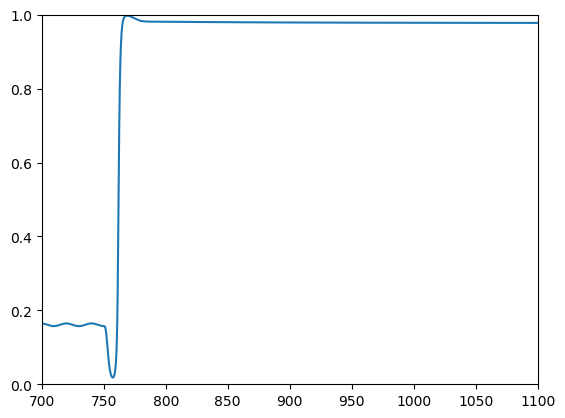

In [37]:
#plot of MrpC2

figure()
plot(t,(X[1]))
xlim(700,1100)
ylim(0,1)
savefig("TIM_delta.pdf")

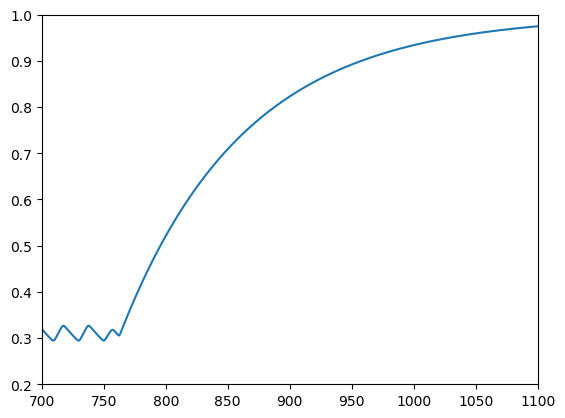

In [38]:
#plot of DevRST
figure()
plot(t,(X[2])) 
xlim(700,1100)
ylim(0.2,1.0)
savefig("DEV_delta.pdf")

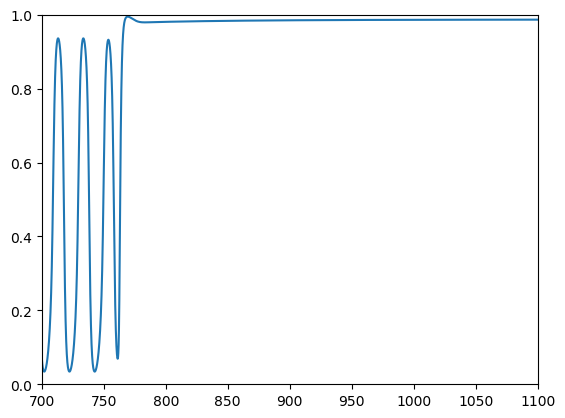

In [39]:
# plot of FruA
figure()
plot(t,(X[3])) 
xlim(700,1100)
ylim(0,1)
savefig("MOV_delta.pdf")

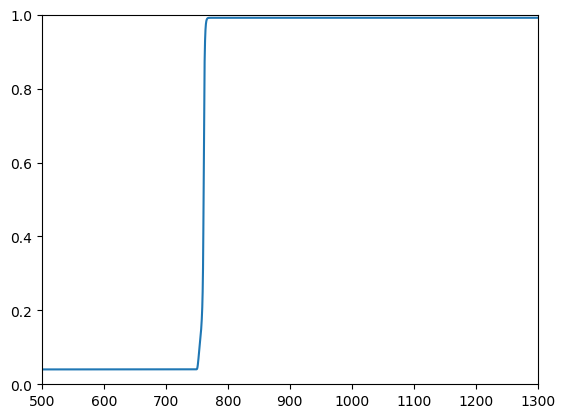

In [16]:
#plot of CsgA
figure()
plot(t,(X[4])) 
xlim(500,1300)
ylim(0,1)
savefig("ADH.pdf")

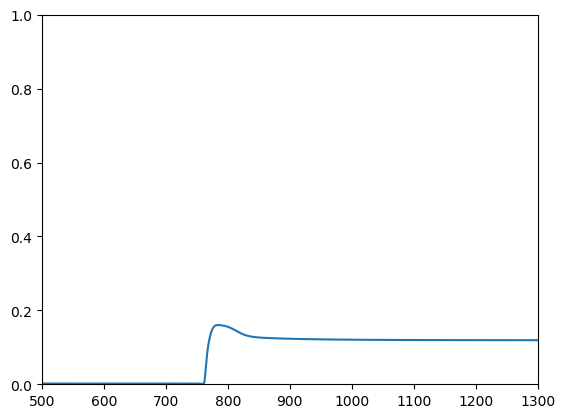

In [33]:
#plot of MazF
figure()
plot(t,(X[5])) 
xlim(500,1300)
ylim(0,1)
savefig("APO_2.pdf")